<a href="https://colab.research.google.com/github/octaviotastico/Text-Mining-2021/blob/main/WordClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Antes que nada, hay que agregar algunas dependencias sino colab se queja.

In [ ]:
!pip install -U setuptools wheel
!pip install -U spacy==3.1.2
!pip install -U pip setuptools wheel
!python -m spacy download es_core_news_md

     |████████████████████████████████| 816 kB 7.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 5.8 MB 10.4 MB/s 
     |████████████████████████████████| 10.1 MB 36.7 MB/s 
     |████████████████████████████████| 623 kB 74.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 456 kB 65.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


     |████████████████████████████████| 1.6 MB 7.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 42.7 MB 47 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.feature_extraction import DictVectorizer

Luego de los imports, creamos las constantes que vamos a necesitar.

Estas variables pueden ser modificadas para ver distintos resultados.

Notar que hay que crear el archivo "lavoztextodump.txt" adentro del directorio "datasets".

In [ ]:
#################
### Constants ###
#################

DATASETS_PATH = './datasets/'
DATASET_1 = DATASETS_PATH + 'lavoztextodump.txt'
MAX_DATASET_SIZE = 2500000
WORD_AMOUNT_THRESHOLD = 25
WORD_CONTEXT_THRESHOLD = 15
MIN_SENTENCE_SIZE = 5
THRESHOLD_VARIANCE = 0.001

Ahora creo una funcion que me va a servir mas adelante, para poder moverla de archivo y olvidarme que existe.

In [ ]:
def setup():
  # Load the spacy model for Spanish language
  # (from here https://spacy.io/models/es)
  nlp = spacy.load("es_core_news_md")

  # Load the stopwords list
  f = open(DATASET_1, "r")
  dataset = f.read()[:MAX_DATASET_SIZE]
  f.close()

  # Load the dataset
  nlp.max_length = MAX_DATASET_SIZE
  return nlp(dataset)

Ademas de "setup", creamos otra funcion que sirva para mas adelante.

In [ ]:
def get_context(features, context, counts):
  for c_word in context:
    c_lemma = c_word.lemma
    if c_word.is_alpha and (counts[c_lemma] > WORD_CONTEXT_THRESHOLD):
      if str.isdigit(str(c_lemma)):
        c_lemma = "NUM__"
      features = features.get(c_lemma, 0) + 1

Agregamos otra funcion que cree los clusters de palabras usando kmeans.

In [ ]:
def clustering(k, red_matrix):
  clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
  clusters = clusterer.cluster(red_matrix, True)
  return clusters

Y finalmente, la ultima antes de comenzar. Esta funcion retorna todas las palabras que esten en un mismo cluster.

In [ ]:
def getWordsInCluster(cluster, search):
  return [word for word in kwords if cluster[kwords[word]] == cluster[kwords[search]]]

Ahora si comenzamos con lo interesante.

Primero llamamos al setup para creamos, y luego nos guardamos las palabras y sus lemmas en dos arreglos distintos.

In [ ]:
doc = setup()
dictionary = {}
discarded_words = []

# Save sentences, if they're long enough
sents = [sent for sent in doc.sents if len(sent) > MIN_SENTENCE_SIZE]

words = []
words_lemma = []
for sent in sents:
  for word in sent:
    if word.is_alpha and word.is_stop == False:
      # Save the word if it's not a number
      # or punctuation sign or a stopword
      words.append(word)
      words_lemma.append(word.lemma_)

counts = Counter(words_lemma)

Con esto, ya podemos generar nuestro diccionario para comenzar a trabajar.

Leer los comentarios para mas detalle de que hace cada linea :)

In [ ]:
for i in range(len(words)):
  features = {} # Dictionary of features
  word = words[i] # Current word
  word_lemma = words_lemma[i] # Current word lemma

  if word.like_num or counts[word_lemma] < WORD_AMOUNT_THRESHOLD: # If the word is a number or it's not frequent enough
    discarded_words.append((word.text, counts[word_lemma])) # Save discarded words to print them later
    continue

  if word_lemma in dictionary: # If the word is already in the dictionary
    features = dictionary[word_lemma] # Get the features of the word

  pos = "POS__" + str(word.pos_) # Part of speech
  dep = "DEP__" + str(word.dep_) # Dependency

  features[pos] = features.get(pos, 0) + 1 # Increase the amount of times the word appears in the same POS
  features[dep] = features.get(dep, 0) + 1 # Increase the amount of times the word appears in the same dependency

  if word.i != 0: # If the word is not the first word of the sentence
    context_left = doc[word.i - 2: word.i] if word.i > 2 else doc[word.i - 1: word.i] # Get the context of the word
    get_context(features, context_left, counts) # Get the features of the context

  if word.i != len(doc) - 1: # If the word is not the last word of the sentence
    context_right = doc[word.i + 1 : word.i + 3] if word.i < len(doc) - 2 else doc[word.i + 1 : word.i + 2] # Get the context of the word
    get_context(features, context_right, counts) # Get the features of the context

  dictionary[word_lemma] = features # Save the features of the word

Printeamos un poco de info interesante.

In [ ]:
# Print top 10 common words
print("Top 10 Most common words:", counts.most_common(10))

# Print top 10 discarded words
if len(discarded_words) > 0:
  discarded_words = list(set(discarded_words))
  discarded_words.sort(key=lambda x: x[1], reverse=True)
  print("Top 10 Discarded words:", discarded_words[:10])

Top 10 Most common words: [('y', 965), ('a', 908), ('año', 140), ('Córdoba', 101), ('ciento', 91), ('o', 86), ('millón', 62), ('provincial', 52), ('Gobierno', 50), ('ley', 48)]
Top 10 Discarded words: [('millón', 62), ('mil', 33), ('seguir', 24), ('vino', 24), ('hijo', 24), ('habríamos', 24), ('permita', 24), ('permitiría', 24), ('participa', 24), ('permitiera', 24)]


Ahora podemos generar las keywords para el diccionario.

In [ ]:
kwords = {} # Dictionary of keywords
all_features = [] # List of all features
for i in range(len(dictionary)): # For each word in the dictionary
  word = list(dictionary.keys())[i] # Current word
  all_features.append(dictionary[word]) # Add the features of the word to the list of all features
  kwords[word] = i # Add the word to the dictionary of keywords

Luego de crear el diccionario de keywords, ahora creamos la matriz de las features.

In [ ]:
v = DictVectorizer(sparse=False) # Create a vectorizer
matrix = v.fit_transform(all_features) # Create the matrix
matrix_normed = matrix / matrix.max(axis=0) # Normalize the matrix

variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0)) # Calculate the variances

red_matrix = np.delete(matrix_normed, np.where(variances < THRESHOLD_VARIANCE), axis=1) # Remove the columns with low variances

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0) # Create a t-SNE object
matrix_dicc2d = tsne.fit_transform(red_matrix) # Create the 2D matrix

Ya tenemos casi todo, ahora podriamos crear un dataframe para graficar las palabras.

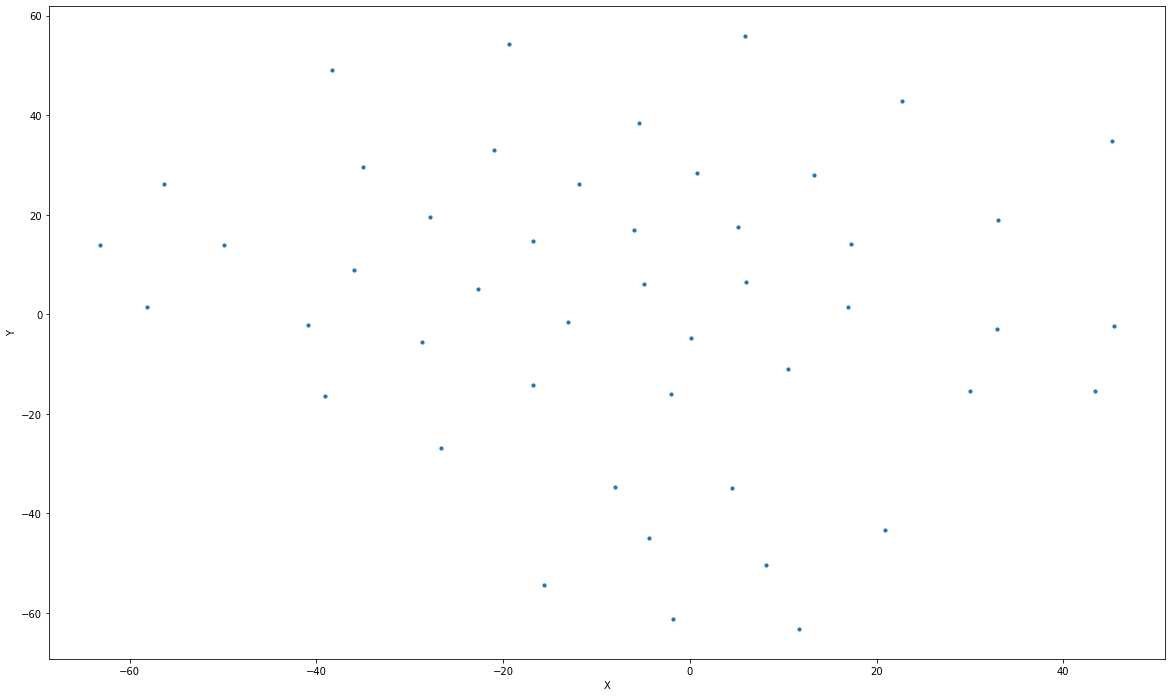

In [ ]:
dataframe = pd.DataFrame( # Create a dataframe with the coordinates of the words
  [
    (word, coords[0], coords[1])
    for word, coords in [
      (word, matrix_dicc2d[kwords[word]])
      for word in kwords
    ]
  ],
  columns=["Word", "X", "Y"]
)

dataframe.plot.scatter("X", "Y", s=10, figsize=(20, 12)) # Plot the words
plt.show() # Show the plot

Ahora podemos crear diferentes clusters para testear lo que hicimos :)

Y jugar creando distintos clusters de palabras, de distinto tamaño y ver que obtenemos.

In [ ]:
cluster_1 = clustering(25, red_matrix) # Create the clusters
cluster_2 = clustering(35, red_matrix) # Create the clusters
cluster_3 = clustering(45, red_matrix) # Create the clusters

In [ ]:
print(getWordsInCluster(cluster_1, "ley"))

['forma', 'ley', 'obra', 'escuela', 'caso', 'país', 'millón', 'elección']


In [ ]:
print(getWordsInCluster(cluster_2, "y"))

['y', 'o']


In [ ]:
print(getWordsInCluster(cluster_3, "país"))

['país']
